##### 1 - IMPORT LIBS #

In [35]:
# --- 1.1 - Libs --- #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

%matplotlib inline
from plotly import graph_objs as go
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords

from tqdm import tqdm
from spacy.util import compounding
from spacy.util import minibatch

import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import os

# --- 1.2 - Configuração dos plots --- #
sns.set_style("whitegrid")
low_memory = False
pd.set_option('display.max_columns', None)

# --- 1.3 - Configuração para imprimir tudo o que existe na célula --- #
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

##### 2 - OBTENÇÃO DA BASE #

In [2]:
# --- 2.1 - Arquivo local --- #
name_file = 'PEDE_PASSOS_DATASET_FIAP.csv'
path = r'C:\Users\Usuario\Desktop\Pessoal\Estudo\FIAP\MBA\Tech Challenge\Fase 5\\'+ name_file
df = pd.read_csv(path, sep=';', on_bad_lines='skip', encoding = 'UTF-8', parse_dates=[0])
df.name = 'df_principal'

##### 3 - CRIAÇÃO DAS FUNÇÕES #

In [3]:
# --- 3.1 - Função para checar se tem valores nulos no dataframe --- #
def check4null(df):
    colunas = len(df.columns)
    soma_nulos = 0
    print("===========",df.name,"===========")
    for i in range(colunas):
        aux = 0
        df_aux = df.iloc[:, i]
        aux = df_aux.isna().sum()
        if aux > 0:
            soma_nulos = soma_nulos + 1
            print(aux, "valor(es) nulo(s) detectado(s) na coluna", df_aux.name, ", pertecente ao dataframe: ", df.name)
        else:
            continue
    if soma_nulos == 0:
        print("Não foram encontrados valores nulos no dataframe: ", df.name)
    else:
        print("Um total de", soma_nulos, "colunas possuem valores nulos no dataframe", df.name)
        print("Foram encontrados valores nulos em ", soma_nulos, "colunas.")
    print("===========",df.name,"===========")
    print("\n")

# --- 3.2 - Função para checar se tem valores duplicados no dataframe --- #
def check4duplicates(df):
    colunas = len(df.columns)
    soma_duplicados = 0
    print("===========", df.name, "===========")
    
    for i in range(colunas):
        aux = 0
        df_aux = df.iloc[:, i]
        aux = df_aux.duplicated().sum()
        if aux > 0:
            soma_duplicados = soma_duplicados + 1
            print(aux, "valor(es) duplicado(s) detectado(s) na coluna", df_aux.name, ", pertencente ao dataframe:", df.name)
        else:
            continue
    
    if soma_duplicados == 0:
        print("Não foram encontrados valores duplicados no dataframe:", df.name)
    else:
        print("Um total de", soma_duplicados, "colunas possuem valores duplicados no dataframe", df.name)
        print("Foram encontrados valores duplicados em", soma_duplicados, "colunas.")
    
    print("===========", df.name, "===========")
    print("\n")

# --- 3.3 - Função que identifica letras em colunas --- #
def check4letters(df):
    colunas = len(df.columns)
    soma_letras = 0
    print("===========", df.name, "===========")
    
    for i in range(colunas):
        df_aux = df.iloc[:, i]
        
        # Identifica as linhas que possuem letras na coluna atual
        has_letters = df_aux.apply(lambda x: isinstance(x, str) and any(char.isalpha() for char in x))
        
        # Conta o número de linhas com letras
        count_letters = has_letters.sum()
        
        if count_letters > 0:
            soma_letras += 1
            print(f"{count_letters} linha(s) com letras detectada(s) na coluna '{df_aux.name}' do DataFrame {df.name}.")
            # Exibe as linhas que possuem letras, se desejado
            #print("Linhas com letras:\n", df[has_letters])
        else:
            continue
    
    if soma_letras == 0:
        print("Não foram encontradas letras em nenhuma coluna do DataFrame:", df.name)
    else:
        print("Um total de", soma_letras, "coluna(s) possuem letras no DataFrame", df.name)
    
    print("===========", df.name, "===========")
    print("\n")

# --- 3.4 - Função que remove as linhas com letras  --- #
def remove_lines(df, column,df_name):
    print("===========", df_name, "===========")
    
    if column in df.columns:
        # Identifica as linhas que possuem letras na coluna especificada
        tem_letra = df[column].apply(lambda x: isinstance(x, str) and any(char.isalpha() for char in x))
        conta_letras = tem_letra.sum()
        
        if conta_letras > 0:
            print(f"Removendo {conta_letras} linha(s) com letras detectada(s) na coluna '{column}' do DataFrame {df_name}.")
            # Remove as linhas com letras
            df = df[~tem_letra]
        else:
            print(f"Não foram encontradas letras na coluna '{column}' do DataFrame {df_name}.")
    else:
        print(f"A coluna '{column}' não existe no DataFrame {df_name}.")
    
    print("===========", df_name, "===========")
    return df

def remove_null(df):
    df_sem_nulos = df.dropna()

    # Retorna o DataFrame sem valores nulos
    return df_sem_nulos

# --- 3.5 - Função disponibilizada no Google Colab do curso --- #
def cleaning_dataset(df):
  _df = df.dropna(subset=df.columns.difference(['NOME']), how='all') # executa o dropna para todas as colunas sem visualizar a coluna NOME
  _df = _df[~_df.isna().all(axis=1)] # remove linhas com apenas NaN, se tiver algum dado na linha não remove
  return _df

# --- 3.6 - Função de separação de anos --- #
def split_year(df):
    
    # Identificar os anos únicos nos nomes das colunas
    anos = set()
    for col in df.columns:
        if col[-4:].isdigit():
            anos.add(col[-4:])
    
    # Criar um DataFrame separado para cada ano, mantendo a coluna 'NOME'
    dataframes_por_ano = {}

    for ano in anos:
        print("\n=== // ===")
        print(f"Iniciando a adequação para o ano {ano}...")
        
        # Selecionar as colunas que correspondem ao ano
        colunas_ano = ['NOME'] + [col for col in df.columns if col.endswith(ano)]
        df_ano = df[colunas_ano].copy()
        
        # Renomear as colunas, removendo o ano do nome
        df_ano.columns = ['NOME'] + [col[:-5] for col in df_ano.columns if col != 'NOME']
        
        # Limpar o DataFrame individual
        df_ano_limpo = cleaning_dataset(df_ano)
        
        dataframes_por_ano[ano] = df_ano_limpo
        
        print(f"Adequação para o ano {ano} concluída.")
        print("=== // ===")
    
    return dataframes_por_ano

##### 4 - LIMPEZA E ADEQUAÇÃO DO CONJUNTO DE DADOS #

In [4]:
# --- 4.1 - Separação do dataframe original para cada um dos anos do estudo --- #
# Execução da função
dataframes = split_year(df)

# Separação
df_2020 = dataframes.get('2020')
df_2020['FASE'] = df_2020['FASE_TURMA'].str.extract(r'(\d+)')
df_2020['TURMA'] = df_2020['FASE_TURMA'].str.extract(r'([A-Za-z]+)')
df_2020 = df_2020.drop('FASE_TURMA',axis=1)
df_2020.name = 'df_2020'
df_2021 = dataframes.get('2021')
df_2021.name = 'df_2021'
df_2022 = dataframes.get('2022')
df_2022.name = 'df_2022'

# Print dos dataframes
print("DataFrame 2020:")
print(df_2020)
print()

print("DataFrame 2021:")
print(df_2021)
print()

print("DataFrame 2022:")
print(df_2022)
print()


=== // ===
Iniciando a adequação para o ano 2020...
Adequação para o ano 2020 concluída.
=== // ===

=== // ===
Iniciando a adequação para o ano 2021...
Adequação para o ano 2021 concluída.
=== // ===

=== // ===
Iniciando a adequação para o ano 2022...
Adequação para o ano 2022 concluída.
=== // ===
DataFrame 2020:
            NOME INSTITUICAO_ENSINO_ALUNO IDADE_ALUNO ANOS_PM PONTO_VIRADA  \
0        ALUNO-1           Escola Pública          11       2          Não   
2        ALUNO-3           Escola Pública          12       2          Não   
3        ALUNO-4           Escola Pública          10       2          Não   
4        ALUNO-5           Escola Pública          10       1          Não   
7        ALUNO-8       Rede Decisão/União          14       3          Sim   
...          ...                      ...         ...     ...          ...   
1340  ALUNO-1341       Rede Decisão/União          17       1          Sim   
1342  ALUNO-1343           Escola Pública          11    

In [5]:
# --- 4.2 - Tratamento de valores nulos/duplicados/incoerentes --- #

# Identificação das linhas com valores nulos
check4null(df_2020)
check4null(df_2021)
check4null(df_2022)

# Identificação das linhas com valores duplicados
check4duplicates(df_2020)
check4duplicates(df_2021)
check4duplicates(df_2022)

# Identificação das linhas com valores letras em colunas numéricas
check4letters(df_2020)
check4letters(df_2021)
check4letters(df_2022)

#  Remoção das linhas incoerentes
df_2020 = remove_lines(df_2020,'INDE_2020','df_2020')
df_2021 = remove_lines(df_2021,'INDE_2021','df_2021')

=========== df_2020 ===========
26 valor(es) nulo(s) detectado(s) na coluna PONTO_VIRADA , pertecente ao dataframe:  df_2020
25 valor(es) nulo(s) detectado(s) na coluna DESTAQUE_IPV , pertecente ao dataframe:  df_2020
Um total de 2 colunas possuem valores nulos no dataframe df_2020
Foram encontrados valores nulos em  2 colunas.
=========== df_2020 ===========


=========== df_2021 ===========
Não foram encontrados valores nulos no dataframe:  df_2021
=========== df_2021 ===========


=========== df_2022 ===========
2 valor(es) nulo(s) detectado(s) na coluna NOTA_PORT , pertecente ao dataframe:  df_2022
2 valor(es) nulo(s) detectado(s) na coluna NOTA_MAT , pertecente ao dataframe:  df_2022
577 valor(es) nulo(s) detectado(s) na coluna NOTA_ING , pertecente ao dataframe:  df_2022
236 valor(es) nulo(s) detectado(s) na coluna REC_AVA_3 , pertecente ao dataframe:  df_2022
577 valor(es) nulo(s) detectado(s) na coluna REC_AVA_4 , pertecente ao dataframe:  df_2022
Um total de 5 colunas possuem 

In [6]:
# --- 4.3 - Junção dos dataframes --- #

def juntar_dataframes_com_ano(df_2020, df_2021, df_2022):
    df_2020['ANO'] = 2020
    df_2021['ANO'] = 2021
    df_2022['ANO'] = 2022
    
    # Concatenar os DataFrames
    df_unificado = pd.concat([df_2020, df_2021, df_2022], ignore_index=True)
    
    return df_unificado

df_unificado = juntar_dataframes_com_ano(df_2020, df_2021, df_2022)
df_unificado = df_unificado[df_unificado["ANOS_PM"] != "D971"]
df_unificado = df_unificado[df_unificado["INSTITUICAO_ENSINO_ALUNO"] != "V202"]
valores_validos_pedra = ["Ametista", "Quartzo", "Topázio", "Ágata"]
df_unificado = df_unificado[df_unificado["PEDRA"].isin(valores_validos_pedra)]

In [7]:
# --- 4.4 - Informações do dataset final --- #
df_unificado.info()
df_unificado.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2273 entries, 0 to 2275
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NOME                      2273 non-null   object 
 1   INSTITUICAO_ENSINO_ALUNO  1411 non-null   object 
 2   IDADE_ALUNO               727 non-null    object 
 3   ANOS_PM                   727 non-null    object 
 4   PONTO_VIRADA              2247 non-null   object 
 5   INDE                      2273 non-null   object 
 6   INDE_CONCEITO             727 non-null    object 
 7   PEDRA                     2273 non-null   object 
 8   DESTAQUE_IEG              1589 non-null   object 
 9   DESTAQUE_IDA              1589 non-null   object 
 10  DESTAQUE_IPV              1565 non-null   object 
 11  IAA                       2273 non-null   object 
 12  IEG                       2273 non-null   object 
 13  IPS                       2273 non-null   object 
 14  IDA     

,NOME,INSTITUICAO_ENSINO_ALUNO,IDADE_ALUNO,ANOS_PM,PONTO_VIRADA,INDE,INDE_CONCEITO,PEDRA,DESTAQUE_IEG,DESTAQUE_IDA,DESTAQUE_IPV,IAA,IEG,IPS,IDA,IPP,IPV,IAN,FASE,TURMA,ANO,SINALIZADOR_INGRESSANTE,REC_EQUIPE_1,REC_EQUIPE_2,REC_EQUIPE_3,REC_EQUIPE_4,NIVEL_IDEAL,DEFASAGEM,ANO_INGRESSO,BOLSISTA,CG,CF,CT,NOTA_PORT,NOTA_MAT,NOTA_ING,QTD_AVAL,REC_AVA_1,REC_AVA_2,REC_AVA_3,REC_AVA_4,INDICADO_BOLSA
0,ALUNO-1,Escola Pública,11,2,Não,7.883752,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.500020000000001,8.7,7.5,7,5.9375,7.75,10,2,H,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALUNO-3,Escola Pública,12,2,Não,7.856389666666666,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.91667,8.9,7.5,5.5,8.125,8.111113333333334,10,3,H,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# --- 4.5 - Contagem básica de valores --- #

# INSTITUICAO_ENSINO_ALUNO
df_unificado[['ANO','INSTITUICAO_ENSINO_ALUNO']].value_counts()
# INSTITUICAO_ENSINO_ALUNO
df_unificado[['ANO','IDADE_ALUNO']].value_counts()
# ANOS_PM
df_unificado[['ANO','ANOS_PM']].value_counts()
# PONTO_VIRADA
df_unificado[['ANO','PONTO_VIRADA']].value_counts()
# PEDRA
df_unificado[['ANO','PEDRA']].value_counts()
# FASE
df_unificado[['ANO','FASE']].value_counts()
# TURMA
df_unificado[['ANO','TURMA']].value_counts()

ANO   INSTITUICAO_ENSINO_ALUNO
2020  Escola Pública              598
2021  Escola Pública              555
      Rede Decisão                127
2020  Rede Decisão/União          101
      FIAP                         11
      UNISA                        10
      Estácio                       3
      Einstein                      2
      Escola João Paulo II          2
2021  Escola JP II                  2
dtype: int64

ANO   IDADE_ALUNO
2020  10             107
      11              93
      12              86
      13              80
      14              72
      9               59
      16              54
      15              50
      17              45
      8               43
      18              21
      7                9
      19               7
      20               1
dtype: int64

ANO   ANOS_PM
2020  1          305
      2          156
      0          134
      3           78
      4           54
dtype: int64

ANO   PONTO_VIRADA
2022  Não             749
2020  Não             607
2021  Não             576
2022  Sim             113
2021  Sim             108
2020  Sim              94
dtype: int64

ANO   PEDRA   
2022  Ametista    348
2020  Ametista    336
2021  Ametista    295
2022  Ágata       250
2021  Ágata       178
2020  Ágata       171
2022  Quartzo     134
      Topázio     130
2020  Quartzo     128
2021  Quartzo     110
      Topázio     101
2020  Topázio      92
dtype: int64

ANO   FASE
2022  1.0     192
      0.0     190
2020  1       172
2021  2.0     162
2020  2       155
2022  2.0     155
      3.0     148
2021  1.0     136
2020  3       122
2021  0.0     120
      3.0     115
2020  0        82
2022  4.0      76
      5.0      60
2021  4.0      59
2020  4        55
      5        54
2021  5.0      50
2020  7        33
      6        30
      8        24
2021  6.0      23
2022  7.0      23
2021  7.0      19
2022  6.0      18
dtype: int64

ANO   TURMA
2020  A        112
2022  A        109
2020  B        106
2021  A         90
2022  B         78
      L         76
      F         70
2020  F         66
2022  K         62
2020  G         59
2021  B         59
      F         57
      G         52
2022  D         49
      M         47
2021  C         47
2020  L         47
2021  L         46
2020  C         45
2021  R         45
2020  H         45
      D         44
      E         44
2021  J         43
2020  M         41
2022  G         40
2021  M         39
2022  J         38
      U         38
2021  E         34
2022  P         33
2020  J         33
2021  N         32
2022  N         32
2020  R         30
2022  C         29
2020  N         28
2022  H         25
      E         23
      Q         22
2021  P         22
      D         22
2022  R         20
      I         20
2021  I         20
      K         15
      S         14
      H         14
      Q         13
2020  K         13
      P         12
2022  O         12


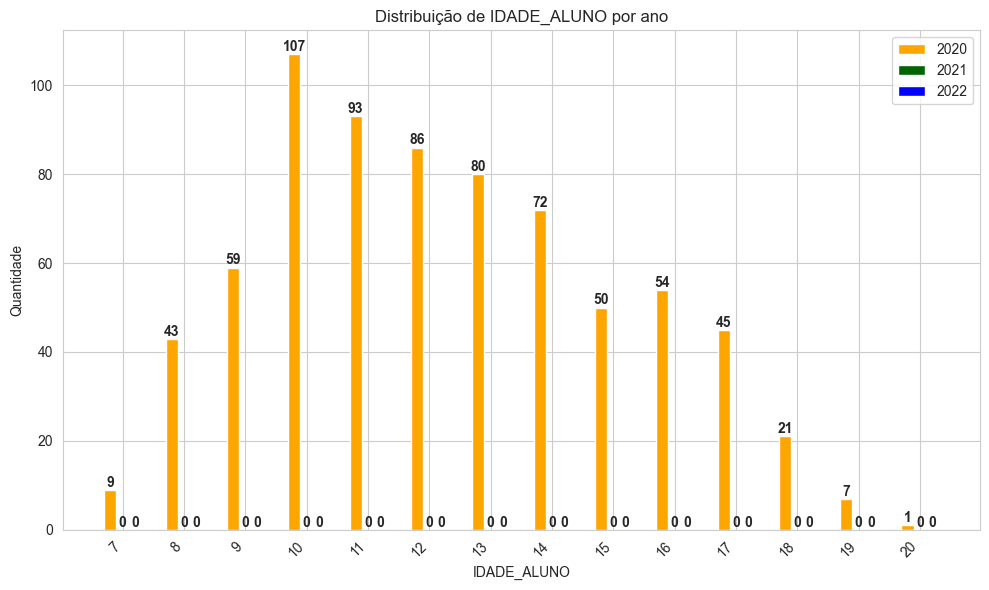

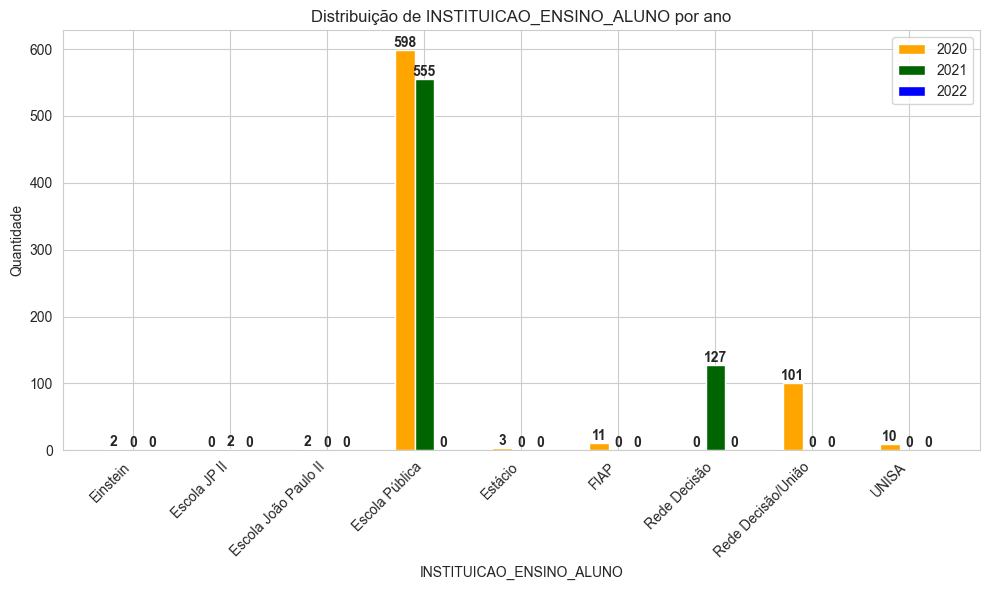

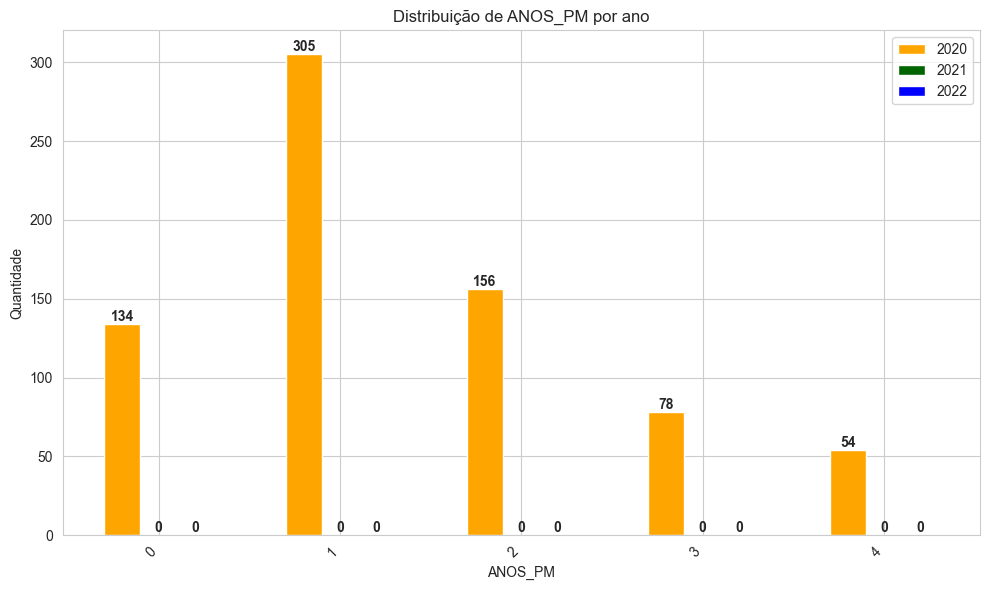

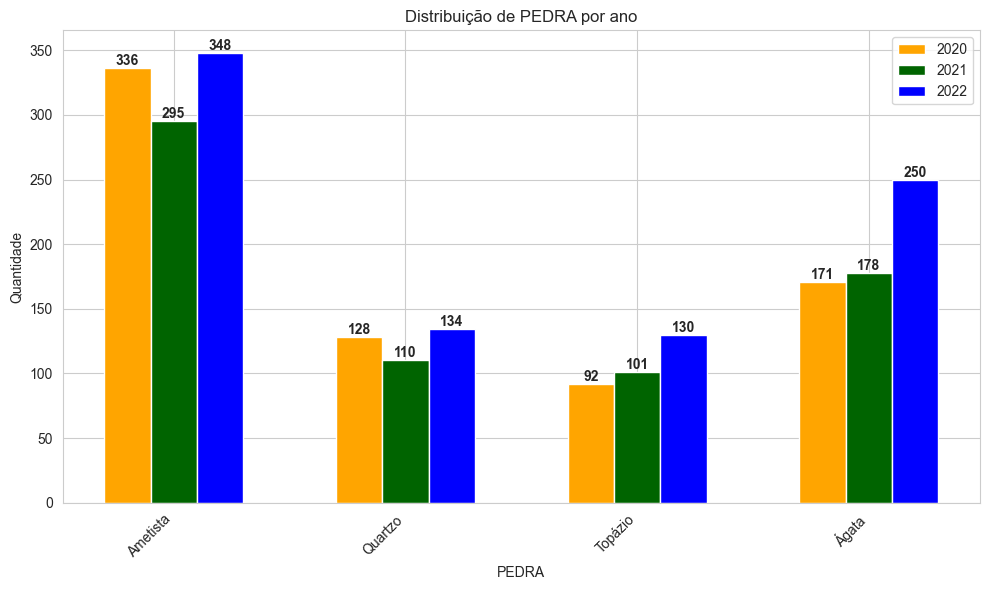

In [9]:
# --- 4.6 - Plot dos gráficos --- #

    # --- 4.6.1 - Criação das funções de plot --- #
def plot_histograms(df, columns, year_column='ANO'):
    colors = {2020: 'orange', 2021: 'darkgreen', 2022: 'blue'}
    for col in columns:
        plt.figure(figsize=(10, 6))
        
        # Remove NaN values and convert all values to strings
        df_filtered = df.dropna(subset=[col])
        df_filtered[col] = df_filtered[col].astype(str)
        
        unique_vals = sorted(df_filtered[col].unique(), key=lambda x: float(x) if x.isdigit() else x)
        
        bar_width = 0.2
        positions = np.arange(len(unique_vals))
        
        for year in colors.keys():
            data = df_filtered[df_filtered[year_column] == year][col]
            counts = [data[data == val].count() for val in unique_vals]
            plt.bar(positions + bar_width*(year-2020), counts, width=bar_width, color=colors[year], label=f'{year}')
            
            # Adding text labels above each bar
            for i, count in enumerate(counts):
                plt.text(i + bar_width*(year-2020), count + 0.01, str(count), ha='center', va='bottom', fontweight='bold')
        
        plt.xticks(positions + bar_width, unique_vals, rotation=45, ha="right")
        plt.xlabel(col)
        plt.ylabel('Quantidade')
        plt.title(f'Distribuição de {col} por ano')
        plt.legend()
        plt.tight_layout()
        plt.show()

columns_to_plot = ['IDADE_ALUNO', 'INSTITUICAO_ENSINO_ALUNO', 'ANOS_PM', 'PEDRA']
plot_histograms(df_unificado, columns_to_plot)

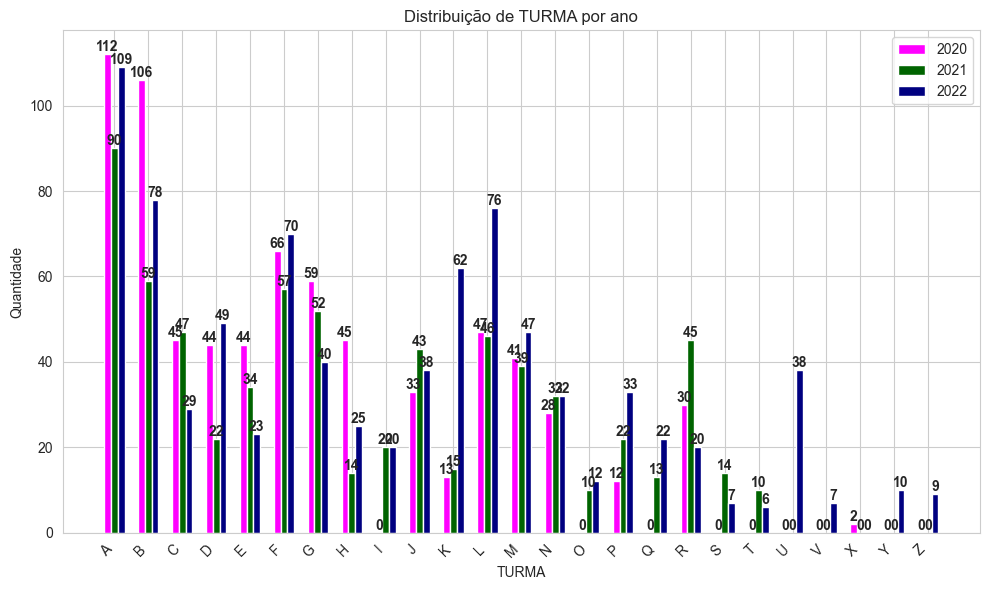

In [10]:
def plot_histograms_turma(df, columns, year_column='ANO'):
    colors = {2020: 'magenta', 2021: 'darkgreen', 2022: 'navy'}
    for col in columns:
        plt.figure(figsize=(10, 6))
        
        # Remove NaN values and ensure all values are strings
        df_filtered = df.dropna(subset=[col])
        df_filtered[col] = df_filtered[col].astype(str)
        
        # Sorting unique values
        unique_vals = sorted(df_filtered[col].unique(), key=lambda x: (x.isdigit(), x))
        
        bar_width = 0.2
        positions = np.arange(len(unique_vals))
        
        for year in colors.keys():
            data = df_filtered[df_filtered[year_column] == year][col]
            counts = [data[data == val].count() for val in unique_vals]
            plt.bar(positions + bar_width*(year-2020), counts, width=bar_width, color=colors[year], label=f'{year}')
            
            # Adding text labels above each bar
            for i, count in enumerate(counts):
                plt.text(i + bar_width*(year-2020), count + 0.01, str(count), ha='center', va='bottom', fontweight='bold')
        
        plt.xticks(positions + bar_width, unique_vals, rotation=45, ha="right")
        plt.xlabel(col)
        plt.ylabel('Quantidade')
        plt.title(f'Distribuição de {col} por ano')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Replot the histograms without "nan" values
columns_to_plot_turma = ['TURMA']
plot_histograms_turma(df_unificado, columns_to_plot_turma)

#### 5 - Previsão de Ponto de Virada

In [11]:
# --- 5.1 - Obtenção do dataframe --- #
df_prev = df_unificado.copy()
df_prev.head(3)
df_prev.name = 'df_prev'

# --- 5.2 - Identificação e remoção de linhas com PONTO_VIRADA como valores nulos --- #
check4null(df_prev)
df_prev['PONTO_VIRADA'][df_prev['PONTO_VIRADA'].isna()].head(26)
df_prev_2 = df_prev.copy().dropna(subset=['PONTO_VIRADA'])
df_prev_2.name = 'df_prev_2'
check4null(df_prev_2)


,NOME,INSTITUICAO_ENSINO_ALUNO,IDADE_ALUNO,ANOS_PM,PONTO_VIRADA,INDE,INDE_CONCEITO,PEDRA,DESTAQUE_IEG,DESTAQUE_IDA,DESTAQUE_IPV,IAA,IEG,IPS,IDA,IPP,IPV,IAN,FASE,TURMA,ANO,SINALIZADOR_INGRESSANTE,REC_EQUIPE_1,REC_EQUIPE_2,REC_EQUIPE_3,REC_EQUIPE_4,NIVEL_IDEAL,DEFASAGEM,ANO_INGRESSO,BOLSISTA,CG,CF,CT,NOTA_PORT,NOTA_MAT,NOTA_ING,QTD_AVAL,REC_AVA_1,REC_AVA_2,REC_AVA_3,REC_AVA_4,INDICADO_BOLSA
0,ALUNO-1,Escola Pública,11,2,Não,7.883752,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.500020000000001,8.7,7.5,7,5.9375,7.75,10,2,H,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALUNO-3,Escola Pública,12,2,Não,7.856389666666666,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.91667,8.9,7.5,5.5,8.125,8.111113333333334,10,3,H,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALUNO-4,Escola Pública,10,2,Não,5.076252,D,Quartzo,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,8.000020000000001,4.1,6.875,0,7.1875,7.75,5,1,D,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=========== df_prev ===========
862 valor(es) nulo(s) detectado(s) na coluna INSTITUICAO_ENSINO_ALUNO , pertecente ao dataframe:  df_prev
1546 valor(es) nulo(s) detectado(s) na coluna IDADE_ALUNO , pertecente ao dataframe:  df_prev
1546 valor(es) nulo(s) detectado(s) na coluna ANOS_PM , pertecente ao dataframe:  df_prev
26 valor(es) nulo(s) detectado(s) na coluna PONTO_VIRADA , pertecente ao dataframe:  df_prev
1546 valor(es) nulo(s) detectado(s) na coluna INDE_CONCEITO , pertecente ao dataframe:  df_prev
684 valor(es) nulo(s) detectado(s) na coluna DESTAQUE_IEG , pertecente ao dataframe:  df_prev
684 valor(es) nulo(s) detectado(s) na coluna DESTAQUE_IDA , pertecente ao dataframe:  df_prev
708 valor(es) nulo(s) detectado(s) na coluna DESTAQUE_IPV , pertecente ao dataframe:  df_prev
1589 valor(es) nulo(s) detectado(s) na coluna SINALIZADOR_INGRESSANTE , pertecente ao dataframe:  df_prev
1589 valor(es) nulo(s) detectado(s) na coluna REC_EQUIPE_1 , pertecente ao dataframe:  df_prev
1589 v

27     NaN
86     NaN
94     NaN
118    NaN
161    NaN
162    NaN
185    NaN
201    NaN
210    NaN
212    NaN
270    NaN
277    NaN
331    NaN
339    NaN
351    NaN
352    NaN
508    NaN
530    NaN
564    NaN
600    NaN
617    NaN
626    NaN
644    NaN
654    NaN
699    NaN
714    NaN
Name: PONTO_VIRADA, dtype: object

=========== df_prev_2 ===========
862 valor(es) nulo(s) detectado(s) na coluna INSTITUICAO_ENSINO_ALUNO , pertecente ao dataframe:  df_prev_2
1546 valor(es) nulo(s) detectado(s) na coluna IDADE_ALUNO , pertecente ao dataframe:  df_prev_2
1546 valor(es) nulo(s) detectado(s) na coluna ANOS_PM , pertecente ao dataframe:  df_prev_2
1546 valor(es) nulo(s) detectado(s) na coluna INDE_CONCEITO , pertecente ao dataframe:  df_prev_2
684 valor(es) nulo(s) detectado(s) na coluna DESTAQUE_IEG , pertecente ao dataframe:  df_prev_2
684 valor(es) nulo(s) detectado(s) na coluna DESTAQUE_IDA , pertecente ao dataframe:  df_prev_2
684 valor(es) nulo(s) detectado(s) na coluna DESTAQUE_IPV , pertecente ao dataframe:  df_prev_2
1563 valor(es) nulo(s) detectado(s) na coluna SINALIZADOR_INGRESSANTE , pertecente ao dataframe:  df_prev_2
1563 valor(es) nulo(s) detectado(s) na coluna REC_EQUIPE_1 , pertecente ao dataframe:  df_prev_2
1563 valor(es) nulo(s) detectado(s) na coluna REC_EQUIPE_2 , pertecente ao data

In [24]:
# --- 5.3 Selecionar as colunas relevantes --- #
colunas_relevantes = [
    'NOME','PONTO_VIRADA', 'DESTAQUE_IEG', 'DESTAQUE_IDA', 'DESTAQUE_IPV', 
    'INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN', 'ANOS_PM', 'BOLSISTA'
]
df_prev_3 = df_prev_2[colunas_relevantes]

# --- 5.4 - Converter as colunas de indicadores para valores numéricos --- #
indicadores = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN', 'ANOS_PM']
df_prev_3[indicadores] = df_prev_3[indicadores].apply(pd.to_numeric, errors='coerce')

# --- 5.5 - Converter a coluna BOLSISTA para numérico (1 para Sim, 0 para Não) --- #
df_prev_3['BOLSISTA'] = df_prev_3['BOLSISTA'].apply(lambda x: 1 if x == 'Sim' else 0)

# --- 5.6 - Exibir as primeiras linhas após as conversões --- #
df_prev_3.head()
df_prev_3.info()
df_prev_3.describe()

,NOME,PONTO_VIRADA,DESTAQUE_IEG,DESTAQUE_IDA,DESTAQUE_IPV,INDE,IAA,IEG,IPS,IDA,IPP,IPV,IAN,ANOS_PM,BOLSISTA
0,ALUNO-1,Não,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.883752,8.50002,8.7,7.500,7.000000,5.9375,7.750000,10.0,2.0,0
1,ALUNO-3,Não,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.856390,7.91667,8.9,7.500,5.500000,8.1250,8.111113,10.0,2.0,0
2,ALUNO-4,Não,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,5.076252,8.00002,4.1,6.875,0.000000,7.1875,7.750000,5.0,2.0,0
3,ALUNO-5,Não,Seu destaque em 2020: A sua boa entrega das li...,Seu destaque em 2020: As suas boas notas na Pa...,Seu destaque em 2020: A sua boa integração aos...,8.077085,7.50002,8.0,7.500,7.500000,8.4375,8.166665,10.0,1.0,0
4,ALUNO-8,Sim,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.381391,8.33334,9.9,4.375,7.333333,8.7500,8.944450,10.0,3.0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2247 entries, 0 to 2275
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NOME          2247 non-null   object 
 1   PONTO_VIRADA  2247 non-null   object 
 2   DESTAQUE_IEG  1563 non-null   object 
 3   DESTAQUE_IDA  1563 non-null   object 
 4   DESTAQUE_IPV  1563 non-null   object 
 5   INDE          2247 non-null   float64
 6   IAA           2247 non-null   float64
 7   IEG           2247 non-null   float64
 8   IPS           2247 non-null   float64
 9   IDA           2247 non-null   float64
 10  IPP           2247 non-null   float64
 11  IPV           2247 non-null   float64
 12  IAN           2247 non-null   float64
 13  ANOS_PM       701 non-null    float64
 14  BOLSISTA      2247 non-null   int64  
dtypes: float64(9), int64(1), object(5)
memory usage: 280.9+ KB


,INDE,IAA,IEG,IPS,IDA,IPP,IPV,IAN,ANOS_PM,BOLSISTA
count,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,701.000000,2247.000000
mean,7.063847,8.262508,7.529011,6.832032,5.927689,7.016371,7.385156,6.852470,1.443652,0.048064
std,1.197839,2.014366,2.129847,1.297416,2.428622,1.342673,1.273828,2.498472,1.116771,0.213949
min,2.468000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,2.500000,0.000000,0.000000
25%,6.390863,7.916670,6.300000,6.250000,4.500000,6.250000,6.800000,5.000000,1.000000,0.000000
50%,7.280371,8.750010,8.100000,7.500000,6.300000,7.343750,7.500000,5.000000,1.000000,0.000000
75%,7.928392,9.500000,9.183767,7.500000,7.666667,7.968750,8.183335,10.000000,2.000000,0.000000
max,9.712504,10.000020,10.000000,10.000000,10.000000,10.000000,10.000010,10.000000,4.000000,1.000000


In [55]:
# --- 5.7 - Separação entre dataset de treino e teste --- #
train, test = train_test_split(df_prev_3, test_size=0.3, random_state=42)
train.info()
test.info()

# --- 5.8 - Montagem do modelo --- #
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

df_prev_3['TEXT_COMBINED'] = df_prev_3['DESTAQUE_IEG'] + " " + df_prev_3['DESTAQUE_IDA'] + " " + df_prev_3['DESTAQUE_IPV']

df_prev_3['TEXT_COMBINED'] = df_prev_3['TEXT_COMBINED'].fillna('')

vectorizer = TfidfVectorizer(max_features=500)
X_text = vectorizer.fit_transform(df_prev_3['TEXT_COMBINED'])

X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())
X_full = pd.concat([X_text_df, df_prev_3[['INDE']].reset_index(drop=True)], axis=1)

y = df_prev_3['PONTO_VIRADA'].apply(lambda x: 1 if x == 'Sim' else 0)

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=777)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(
    n_estimators=1000, 
    min_samples_split=10, 
    min_samples_leaf=5,     
    random_state=777
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1572 entries, 1251 to 888
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NOME               1572 non-null   object 
 1   PONTO_VIRADA       1572 non-null   object 
 2   DESTAQUE_IEG       1082 non-null   object 
 3   DESTAQUE_IDA       1082 non-null   object 
 4   DESTAQUE_IPV       1082 non-null   object 
 5   INDE               1572 non-null   float64
 6   IAA                1572 non-null   float64
 7   IEG                1572 non-null   float64
 8   IPS                1572 non-null   float64
 9   IDA                1572 non-null   float64
 10  IPP                1572 non-null   float64
 11  IPV                1572 non-null   float64
 12  IAN                1572 non-null   float64
 13  ANOS_PM            468 non-null    float64
 14  BOLSISTA           1572 non-null   int64  
 15  TEXT_COMBINED      1572 non-null   object 
 16  PRED_PONTO_VIRADA  157

RandomForestClassifier(min_samples_leaf=5, min_samples_split=10,
                       n_estimators=1000, random_state=777)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       572
           1       0.74      0.50      0.59       103

    accuracy                           0.90       675
   macro avg       0.83      0.73      0.77       675
weighted avg       0.89      0.90      0.89       675



In [56]:
# Predizer o "Ponto de Virada" para o conjunto de dados original
df_prev_3['PRED_PONTO_VIRADA'] = model.predict(X_full)

# Criar o DataFrame de validação
df_prev_3['PRED_PONTO_VIRADA'] = df_prev_3['PRED_PONTO_VIRADA'].apply(lambda x: 'Sim' if x == 1 else 'Não')
df_validacao = df_prev_3[['NOME', 'DESTAQUE_IEG', 'DESTAQUE_IDA', 'DESTAQUE_IPV', 'INDE', 'PONTO_VIRADA', 'PRED_PONTO_VIRADA']]

# Verificar quais linhas têm diferenças entre o valor real e o previsto
df_validacao['DIFERENCA'] = df_validacao['PONTO_VIRADA'] == df_validacao['PRED_PONTO_VIRADA']

# Exibir o DataFrame de validação
df_validacao

,NOME,DESTAQUE_IEG,DESTAQUE_IDA,DESTAQUE_IPV,INDE,PONTO_VIRADA,PRED_PONTO_VIRADA,DIFERENCA
0,ALUNO-1,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.883752,Não,Não,True
1,ALUNO-3,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.856390,Não,Não,True
2,ALUNO-4,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,5.076252,Não,Não,True
3,ALUNO-5,Seu destaque em 2020: A sua boa entrega das li...,Seu destaque em 2020: As suas boas notas na Pa...,Seu destaque em 2020: A sua boa integração aos...,8.077085,Não,Não,True
4,ALUNO-8,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.381391,Sim,Sim,True
...,...,...,...,...,...,...,...,...
2271,ALUNO-1342,Destaque: A sua boa entrega das lições de casa.,Destaque: As suas boas notas na Passos Mágicos.,Destaque: A sua boa integração aos Princípios ...,8.150001,Não,Não,True
2272,ALUNO-1343,Melhorar: Melhorar a sua entrega de lições de ...,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Melhorar: Integrar-se mais aos Princípios Pass...,5.674644,Não,Não,True
2273,ALUNO-1346,Destaque: A sua boa entrega das lições de casa.,Destaque: As suas boas notas na Passos Mágicos.,Destaque: A sua boa integração aos Princípios ...,8.135538,Sim,Não,False
2274,ALUNO-1348,Destaque: A sua boa entrega das lições de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Melhorar: Integrar-se mais aos Princípios Pass...,6.749981,Não,Não,True


Salvando

In [57]:
df_validacao.to_csv('df_validacao.csv', index=False)

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

<Figure size 800x600 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 36.72222222222221, 'Predicted')

Text(70.72222222222221, 0.5, 'Actual')

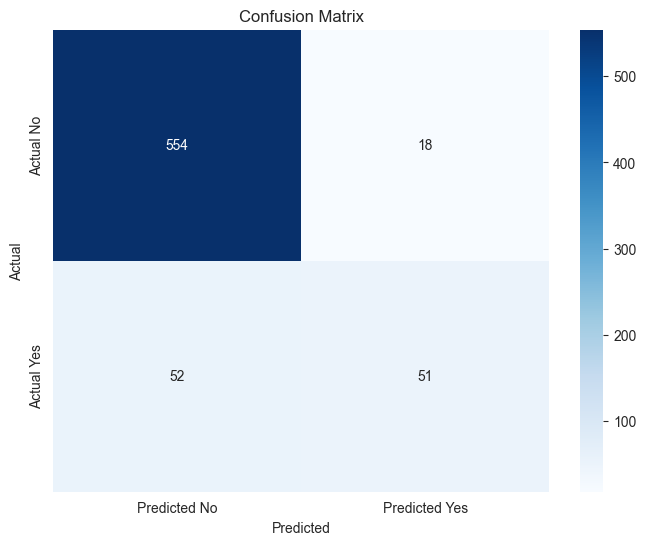

In [59]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming y_test and y_pred are available from the model evaluation# For demonstration, I'll simulate these arrays. Replace with your actual y_test and y_pred.import numpy as np
y_test = np.array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0])
y_pred = np.array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0])

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the main indicators
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate False Positive Rate and False Negative Rate
false_positive_rate = cm[0, 1] / (cm[0, 1] + cm[0, 0])
false_negative_rate = cm[1, 0] / (cm[1, 0] + cm[1, 1])

# Creating a dictionary to display all the results
metrics = {
    "Acurácia": accuracy,
    "Precisão": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Taxa de Falsos Positivos (FPR)": false_positive_rate,
    "Taxa de Falsos Negativos (FNR)": false_negative_rate
}

metrics

{'Acurácia': 0.8,
 'Precisão': 0.8,
 'Recall': 0.8,
 'F1-Score': 0.8000000000000002,
 'Taxa de Falsos Positivos (FPR)': 0.2,
 'Taxa de Falsos Negativos (FNR)': 0.2}